In [1]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
import rebound
import numpy as np
from numpy import pi as PI
from numpy import sin
from numpy.random import rand
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (4, 3)

In [2]:
N_testparticle = 500

- 怎么将小天体的轨道中心设置在太阳？在`sim.add`里面使用`primary=sim.particles['sun']`得到的结果不对劲。
- 在确定flyby和黄道面的倾角之后，如何确定flyby近心点的位置？（不同的近心点位置甚至会有穿过黄道面1次和2次的区别）

### 生成小天体的a和inc分布

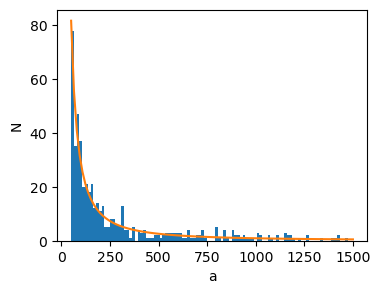

In [6]:
# sample a
a_pdf_func = lambda x:x**(-1.5)

# np.random.seed(0)
a_rand = np.random.rand(10000)*1450 + 50 # a in [50, 1500]
a_pdf = a_pdf_func(a_rand)
a_pdf = a_pdf/a_pdf.sum()
a = np.random.choice(a_rand, size=N_testparticle, replace=True, p=a_pdf)

plt.hist(a, bins=100)
x = np.linspace(50, 1500, 100)
x_pdf = a_pdf_func(x)
x_pdf = x_pdf/x_pdf.sum()
plt.plot(x, x_pdf*N_testparticle)
plt.ylabel("N")
plt.xlabel("a")
plt.show()

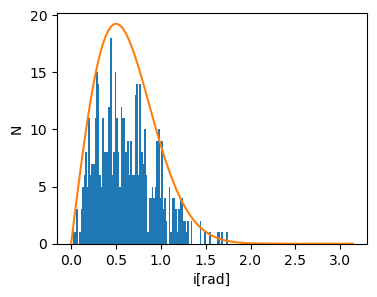

In [7]:
# sample i

inc_pdf_func = lambda x:sin(x)*norm.pdf(x, loc=0, scale=15/180*2*PI)

inc_rand = np.random.rand(10000)*PI # i in [0, 90]
inc_pdf = inc_pdf_func(inc_rand)
inc_pdf = inc_pdf/inc_pdf.sum()
inc = np.random.choice(inc_rand, size=N_testparticle, replace=True, p=inc_pdf)

plt.hist(inc, bins=100)
x = np.linspace(0, PI ,100)
x_pdf = inc_pdf_func(x)
x_pdf = x_pdf/x_pdf.sum()
plt.plot(x, x_pdf*N_testparticle)
plt.ylabel("N")
plt.xlabel("i[rad]")
plt.show()


### sim模拟设置

In [82]:
sim.stop_server()

In [3]:
# del sim

sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')
print("G = {0}.".format(sim.G))

# sim.exit_max_distance = 20000.

# sim.heartbeat=heratbeat
sim.integrator = "whfast"
sim.dt = 0.5

sim.add(m=1., hash='sun')

# 已知v_inf和q求解b(y)，注意要保证轨道是抛物线（E>0）
# sim.add(m=1., x=15000, y=1075, vx=-0.05, hash='flyby')
# sim.add(m=1., a=-1775.19, e=1.17, inc=PI/2, pomega=0, l=-2*PI, hash='flyby')
sim.add(m=1., a=-1775.19, e=4, inc=PI/2, pomega=0, l=10, hash='flyby')
# pomega in [-pi, pi]


sim.status(showAllFields=False)
# sim.widget(size=(400,400))
sim.start_server(port=1234)

G = 39.476926421373.
---------------------------------
REBOUND version:     	4.3.2
REBOUND built on:    	Feb 19 2024 16:09:36
Number of particles: 	2
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.500000
---------------------------------
<rebound.particle.Particle object at 0x7fb6116d3040, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.particle.Particle object at 0x7fb6116d30c0, m=1.0 x=1570.1002599294677 y=1.24220704219332e-12 z=20286.780532283967 vx=-0.05429024182870444 vy=1.3594326639462781e-17 vz=0.22201220219458673>
---------------------------------
REBOUND Webserver listening on http://localhost:1234 ...


In [5]:
p = sim.particles['flyby']
flyby_d= np.sqrt(p.x**2+p.y**2+p.z**2)
print('initial d : %.1f au'%flyby_d)

initial d : 20347.4 au


In [8]:
for j in range(N_testparticle):
    q = rand()*20+5
    while q>a[j]:
        q = rand()*20+5
    # print(q)
    # print(a[i])
    e = 1-q/a[j]
    # print(e)
    # look in OrbitalElements.ipynb
    sim.add(primary=sim.particles['sun'], a=a[j], e=e, inc=inc[j], 
            l=rand()*2.*PI, pomega=rand()*2.*PI)#, Omega=rand()*2.*PI)
    # l = Omega + omega + M, the position of the particle in the orbit, well defined for e=0
    # pomega = Omega + omege, is the angel from the x-axis to the pericenter, well defined for i=0

sim.status(showAllFields=False, showParticles=False)

---------------------------------
REBOUND version:     	4.3.2
REBOUND built on:    	Feb 19 2024 16:09:36
Number of particles: 	502
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.500000
---------------------------------


### 画出小天体初始的轨道参数

In [42]:
a_initial = np.zeros(N_testparticle)
e_initial = np.zeros(N_testparticle)
q_initial = np.zeros(N_testparticle)
inc_initial = np.zeros(N_testparticle)
pomega_initial = np.zeros(N_testparticle)

for i in range(N_testparticle):
    orbit = sim.particles[i+2].orbit(primary=sim.particles['sun'])
    a_initial[i] = orbit.a
    q_initial[i] = orbit.a*(1-orbit.e)
    e_initial[i] = orbit.e
    inc_initial[i] = orbit.inc
    pomega_initial[i] = orbit.pomega


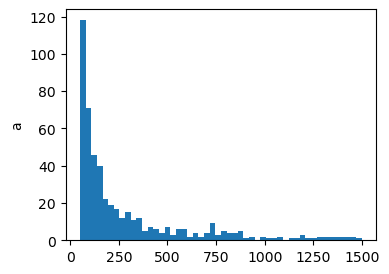

In [43]:
plt.hist(a_initial, bins=50)
plt.ylabel('a')
plt.show()

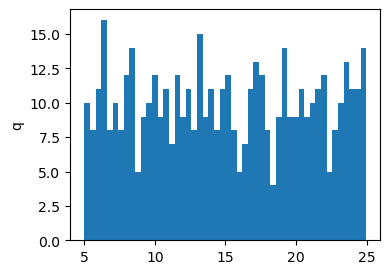

In [44]:
plt.hist(q_initial, bins=50)
plt.ylabel('q')
plt.show()

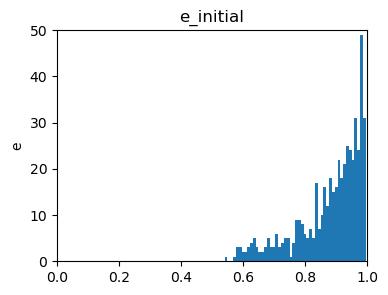

In [45]:
plt.hist(e_initial, bins=50)
plt.ylabel('e')
plt.xlim(0, 1)
plt.ylim(0, 50)
plt.title('e_initial')
plt.show()

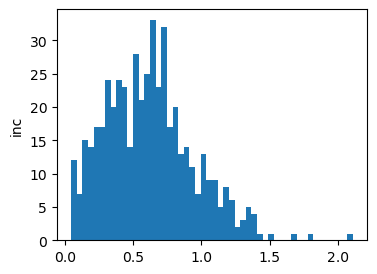

In [46]:
plt.hist(inc_initial, bins=50)
plt.ylabel('inc')
plt.show()

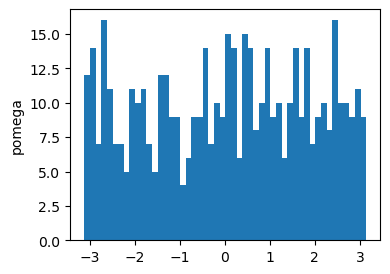

In [47]:
plt.hist(pomega_initial, bins=50)
plt.ylabel('pomega')
plt.show()

### 继续sim

In [9]:
sim.N_active = 2
sim.move_to_com()

In [10]:
sim.integrate(2e5)

KeyboardInterrupt: 


REBOUND Webserver error: Did not get request.

REBOUND Webserver error: Did not get request.


In [50]:
# Noutputs = 10000
# times = np.linspace(0,5e4,Noutputs)
# for i,time in enumerate(times):
#     try:
#         sim.integrate(time)
#     except rebound.Escape as error:
#         for j in range(sim.N):
#             p = sim.particles[j]
#             d2 = p.x*p.x + p.y*p.y + p.z*p.z
#             if d2>sim.exit_max_distance**2:
#                 index=j # cache index rather than remove here since our loop would go beyond end of particles array
#         sim.remove(index=index)

In [51]:
# N_remain = sim.N - 2
# print("escape:", N_testparticle - N_remain)

### plot结果

In [52]:
names = ['sedna', 'VP113', 'L']
a_sednoid = np.array([506.4, 262.0, 1089.6])
q_sednoid = np.array([76.2, 80.5, 65.0])
inc_sednoid = np.array([11.9, 24.1, 11.7])*PI/180
pomega_sednoid = -PI/9

In [53]:
N_remain = N_testparticle

a_final = np.zeros(N_remain)
e_final = np.zeros(N_remain)
q_final = np.zeros(N_remain)
inc_final = np.zeros(N_remain)
pomega_final = np.zeros(N_remain)

for i in range(N_remain):
    orbit = sim.particles[i+2].orbit(primary=sim.particles['sun'])
    a_final[i] = orbit.a
    q_final[i] = orbit.a*(1-orbit.e)
    e_final[i] = orbit.e
    inc_final[i] = orbit.inc
    pomega_final[i] = orbit.pomega


In [54]:
flyby_orbit = sim.particles[1].orbit(primary=sim.particles['sun'])
print(flyby_orbit.pomega)
print(flyby_orbit.l/PI)
flyby_p = sim.particles['flyby']
flyby_d = np.sqrt(flyby_p.x**2 + flyby_p.y**2 + flyby_p.z**2)
print(flyby_d)

0.0
0.43690557206843483
17835.158338242905


In [55]:
ind_bound = a_final>0
ind_close = a_final<5000
ind_qclose = q_final<1200
ind_valid = ind_bound*ind_close*ind_qclose
sum(ind_valid)

339

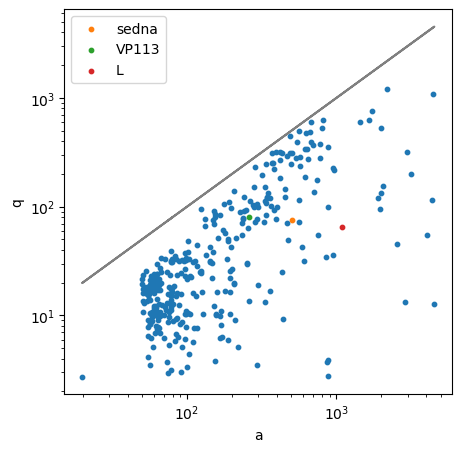

In [56]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(a_final[ind_valid], q_final[ind_valid],s=10)
ax.plot(a_final[ind_valid], a_final[ind_valid],c='gray')
for i in range(3):
    ax.scatter(a_sednoid[i], q_sednoid[i], label=names[i],s=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('q')
ax.set_xlabel('a')
ax.legend()
plt.show()

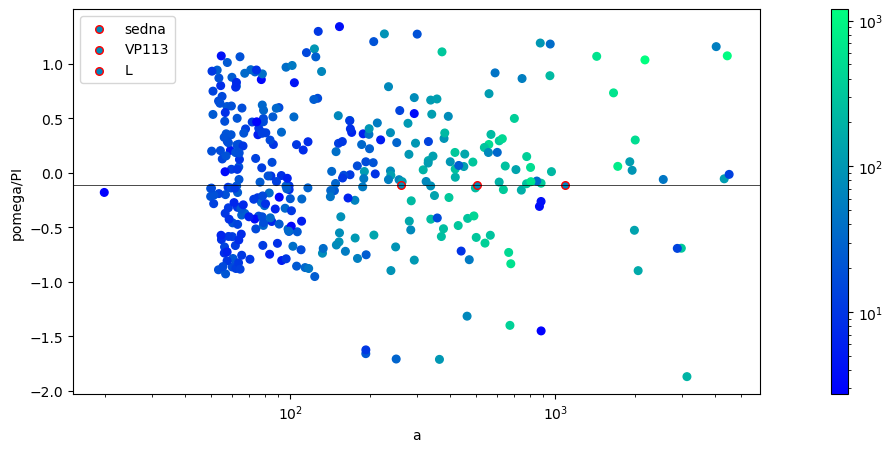

In [57]:
import matplotlib as mpl
cmap = mpl.colormaps.get_cmap(mpl.cm.winter)
norm = mpl.colors.LogNorm(vmin=min(q_final[ind_valid]),vmax=max(q_final[ind_valid]))

q_color = cmap(norm(q_final[ind_valid]))

fig, axes = plt.subplots(1, 2, figsize=(10, 5), width_ratios=[40,1])
dotsize = 30

ax = axes[0]
ax.scatter(a_final[ind_valid], pomega_final[ind_valid]/PI, color=q_color,s=dotsize)

for i in range(3):
    ax.scatter(a_sednoid[i],pomega_sednoid/PI,facecolor=cmap(norm(q_sednoid[i])),edgecolor='r',label=names[i],s=dotsize)

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(im, cax=axes[1], orientation='vertical')

ax.axhline((180-200)/180,c='k',lw=0.5)
ax.set_xscale('log')
ax.set_xlabel('a')
ax.set_ylabel('pomega/PI')
ax.legend()
plt.show()

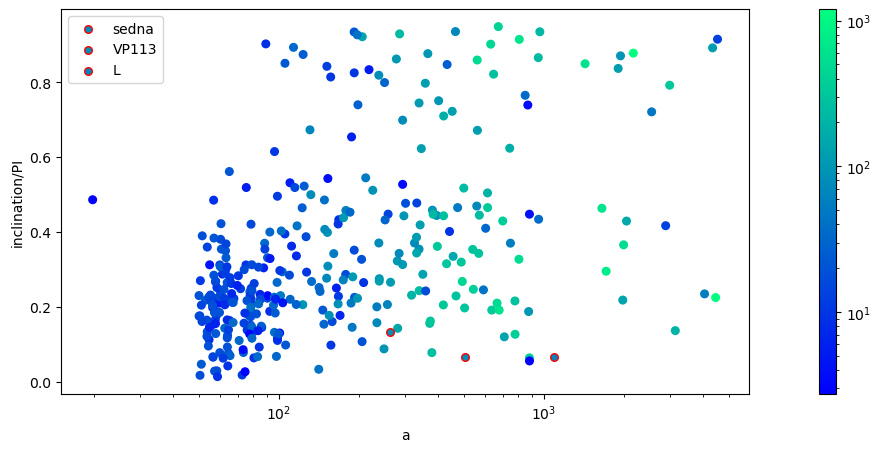

In [58]:
import matplotlib as mpl
cmap = mpl.colormaps.get_cmap(mpl.cm.winter)
norm = mpl.colors.LogNorm(vmin=min(q_final[ind_valid]),vmax=max(q_final[ind_valid]))

q_color = cmap(norm(q_final[ind_valid]))

fig, axes = plt.subplots(1, 2, figsize=(10, 5), width_ratios=[40,1])
dotsize = 30

ax = axes[0]
ax.scatter(a_final[ind_valid], inc_final[ind_valid]/PI, color=q_color,s=dotsize)

for i in range(3):
    ax.scatter(a_sednoid[i],inc_sednoid[i]/PI,facecolor=cmap(norm(q_sednoid[i])),edgecolor='r',label=names[i],s=dotsize)

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(im, cax=axes[1], orientation='vertical')

# ax.axhline((180-200)/180,c='k',lw=0.5)
ax.set_xscale('log')
ax.set_xlabel('a')
ax.set_ylabel('inclination/PI')
ax.legend()
plt.show()

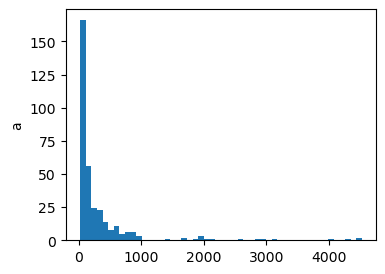

In [59]:
plt.hist(a_final[ind_valid], bins=50)
plt.ylabel('a')
# plt.xscale('log')
plt.show()

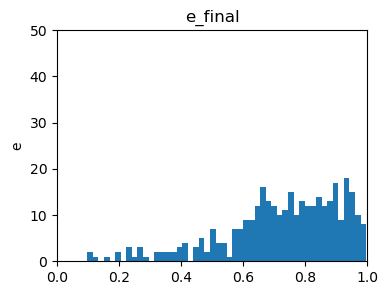

In [60]:
plt.hist(e_final[ind_valid], bins=50)
plt.ylabel('e')
plt.xlim(0, 1)
plt.ylim(0, 50)
plt.title('e_final')
plt.show()

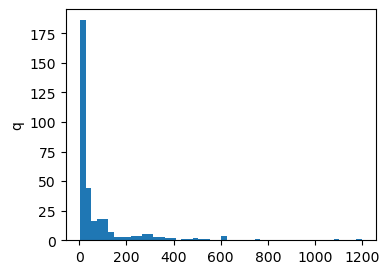

In [61]:
plt.hist(q_final[ind_valid], bins=50)
plt.ylabel('q')
plt.show()

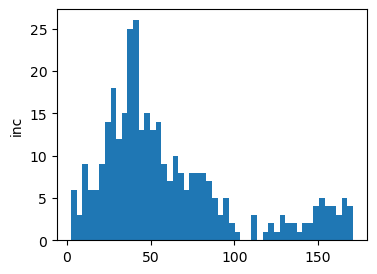

In [62]:
plt.hist(inc_final[ind_valid]*180/PI, bins=50)
plt.ylabel('inc')
plt.show()

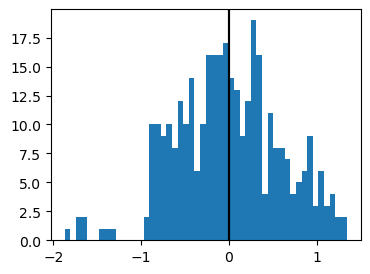

In [63]:
plt.hist(pomega_final[ind_valid]/PI, bins=50)
plt.axvline(flyby_orbit.pomega/PI, c='k')
plt.axvline(-flyby_orbit.pomega/PI, c='k')
plt.show()

(-1.0, 1.0)

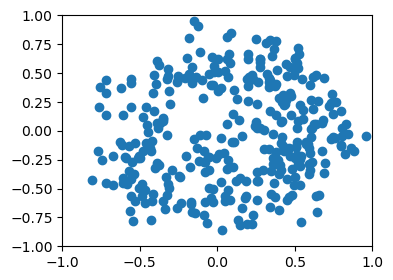

In [68]:
Gamma = 1 - np.sqrt(1-e_final[ind_valid]**2)
plt.scatter(np.sqrt(Gamma)*np.cos(pomega_final[ind_valid]), np.sqrt(Gamma)*np.sin(pomega_final[ind_valid]))
plt.ylim(-1, 1)
plt.xlim(-1, 1)

In [64]:
print(kjs)

NameError: name 'kjs' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

In [ ]:
# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(a_final[ind_valid], pomega_final[ind_valid], ax, ax_histx, ax_histy)
ax.set_xscale('log')
ax.set_yscale('log')

Error in callback <function flush_figures at 0x7f4faad118b0> (for post_execute):


KeyboardInterrupt: 